In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load gas line map NGC4501_gas_BIN_maps.fits 
gas_path = Path('NGC4501_gas_BIN_maps_extended.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")
    gas_header = hdul[5].header
    hdul.close()
print("All data loaded successfully!")

gas_header

Loading gas line map from NGC4501_gas_BIN_maps_extended.fits
Available extensions: ['BIN_ID', 'V_STARS2', 'SIGMA_STARS2', 'CHI2_TOT', 'HB4861_FLUX', 'HB4861_FLUX_ERR', 'HB4861_VEL', 'HB4861_VEL_ERR', 'HB4861_SIGMA', 'HB4861_SIGMA_ERR', 'HB4861_SIGMA_CORR', 'OIII4958_FLUX', 'OIII4958_FLUX_ERR', 'OIII4958_VEL', 'OIII4958_VEL_ERR', 'OIII4958_SIGMA', 'OIII4958_SIGMA_ERR', 'OIII4958_SIGMA_CORR', 'OIII5006_FLUX', 'OIII5006_FLUX_ERR', 'OIII5006_VEL', 'OIII5006_VEL_ERR', 'OIII5006_SIGMA', 'OIII5006_SIGMA_ERR', 'OIII5006_SIGMA_CORR', 'NI5197_FLUX', 'NI5197_FLUX_ERR', 'NI5197_VEL', 'NI5197_VEL_ERR', 'NI5197_SIGMA', 'NI5197_SIGMA_ERR', 'NI5197_SIGMA_CORR', 'NI5200_FLUX', 'NI5200_FLUX_ERR', 'NI5200_VEL', 'NI5200_VEL_ERR', 'NI5200_SIGMA', 'NI5200_SIGMA_ERR', 'NI5200_SIGMA_CORR', 'NII5754_FLUX', 'NII5754_FLUX_ERR', 'NII5754_VEL', 'NII5754_VEL_ERR', 'NII5754_SIGMA', 'NII5754_SIGMA_ERR', 'NII5754_SIGMA_CORR', 'HEI5875_FLUX', 'HEI5875_FLUX_ERR', 'HEI5875_VEL', 'HEI5875_VEL_ERR', 'HEI5875_SIGMA', 'HEI58

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1205                                                  
NAXIS2  =                 1236                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      981.81124934049 / Pixel coordinate of reference point            
CRPIX2  =      828.78943180107 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [3]:
kin_path = Path('NGC4501_KIN_maps_extended.fits')
if kin_path.exists():
    print(f"Loading kinematic map from {kin_path}")
    with fits.open(kin_path) as hdul:
        kin_info = hdul.info()
        
        # Read data from all extensions except PRIMARY
        extension_names = [hdul[i].name for i in range(1, len(hdul))]
        print(f"Available extensions: {extension_names}")
        
        # Read each extension's data before closing the file
        for ext_name in extension_names:
            if ext_name and ext_name != "PRIMARY":
                globals()[ext_name] = hdul[ext_name].data
                print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")
    
    print("All data loaded successfully!")
    hdul.close()
    # Invert the true/false in FOREGROUND_STAR, but except the nan values
    non_FOREGROUND_STAR = np.where(np.isnan(FOREGROUND_STAR), np.nan, ~FOREGROUND_STAR.astype(bool))

    V_STARS2 = np.where(non_FOREGROUND_STAR, V_STARS2, np.nan)
    SIGMA_STARS2 = np.where(non_FOREGROUND_STAR, SIGMA_STARS2, np.nan)
    HB4861_FLUX = np.where(non_FOREGROUND_STAR, HB4861_FLUX, np.nan)
    HB4861_FLUX_ERR = np.where(non_FOREGROUND_STAR, HB4861_FLUX_ERR, np.nan)
    HA6562_FLUX = np.where(non_FOREGROUND_STAR, HA6562_FLUX, np.nan)
    HA6562_FLUX_ERR = np.where(non_FOREGROUND_STAR, HA6562_FLUX_ERR, np.nan)
    OIII5006_FLUX = np.where(non_FOREGROUND_STAR, OIII5006_FLUX, np.nan)
    OIII5006_FLUX_ERR = np.where(non_FOREGROUND_STAR, OIII5006_FLUX_ERR, np.nan)
    NII6583_FLUX = np.where(non_FOREGROUND_STAR, NII6583_FLUX, np.nan)
    NII6583_FLUX_ERR = np.where(non_FOREGROUND_STAR, NII6583_FLUX_ERR, np.nan)
    SII6716_FLUX = np.where(non_FOREGROUND_STAR, SII6716_FLUX, np.nan)
    SII6716_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6716_FLUX_ERR, np.nan)
    SII6730_FLUX = np.where(non_FOREGROUND_STAR, SII6730_FLUX, np.nan)
    SII6730_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6730_FLUX_ERR, np.nan)
    print("Foreground stars are removed successfully!")

else:
    print(f"File not found: {kin_path}")

File not found: NGC4501_KIN_maps_extended.fits


In [4]:
binning_path = Path('NGC4501_SPATIAL_BINNING_maps_extended.fits')
print(f"Loading kinematic map from {binning_path}")
with fits.open(binning_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            if kin_path.exists():
                globals()[ext_name] = np.where(non_FOREGROUND_STAR, globals()[ext_name], np.nan)
            else:
                pass
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")
    hdul.close()
print("All data loaded successfully!")

Loading kinematic map from NGC4501_SPATIAL_BINNING_maps_extended.fits
Filename: NGC4501_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (1205, 1236)   float64   
  2  FLUX          1 ImageHDU        26   (1205, 1236)   float64   
  3  SNR           1 ImageHDU        26   (1205, 1236)   float64   
  4  SNRBIN        1 ImageHDU        26   (1205, 1236)   float64   
  5  XBIN          1 ImageHDU        26   (1205, 1236)   float64   
  6  YBIN          1 ImageHDU        26   (1205, 1236)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (1205, 1236)   float64   
  8  ML_R          1 ImageHDU        27   (1205, 1236)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (1205, 1236)   float64   
 10  LOGMASS_SURFACE_DENSITY    1 ImageHDU        27   (1205, 1236)   float64   
 11  MAGNITUDE_R    1 ImageHDU        27   (1205, 1236)   float64   
 

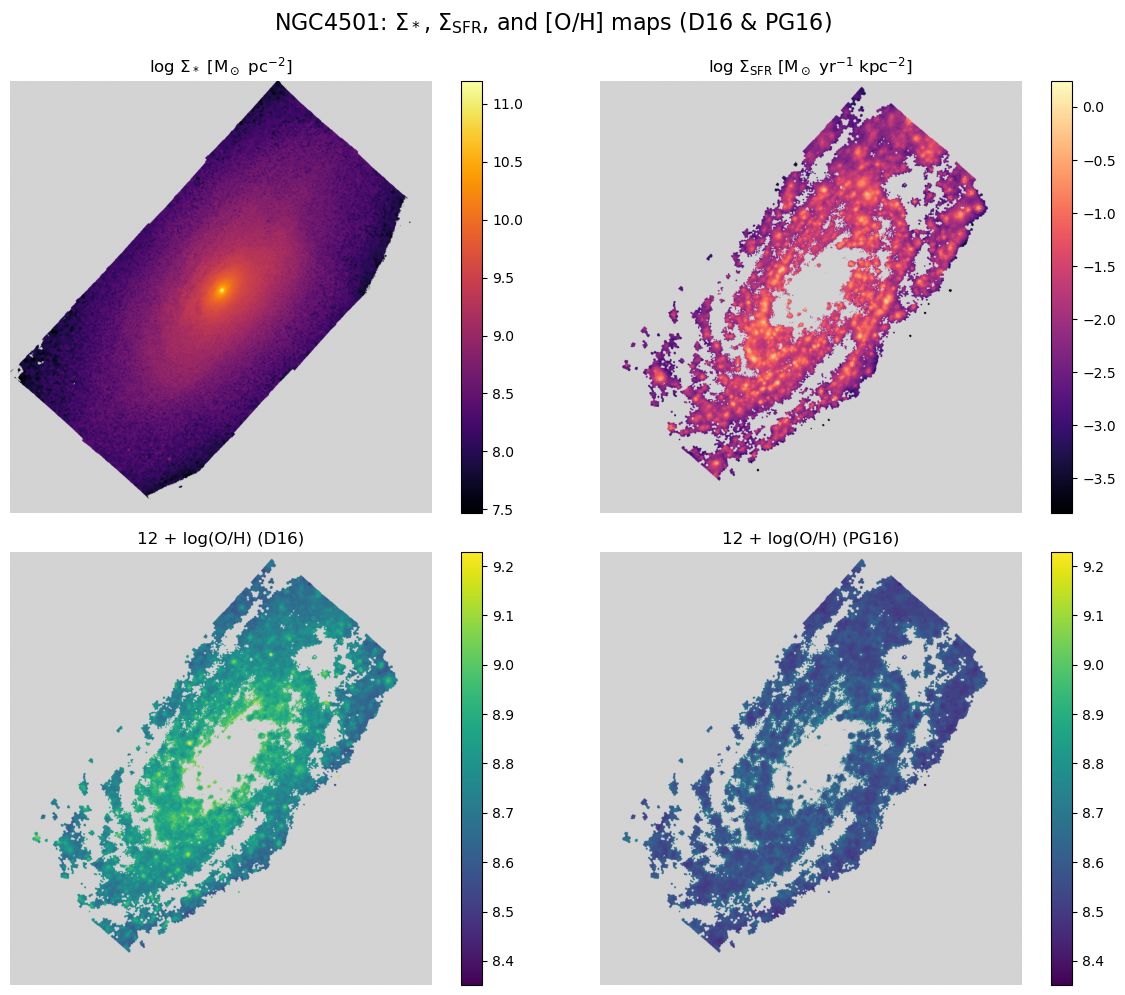

In [8]:
# --------------------------------------------------------------
# Maps: Σ* map, Σ_SFR map, and [O/H] maps (D16 & PG16) for each galaxy
# --------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pathlib import Path
from astropy.io import fits
import re

# Extraction functions for log files (kept in case titles/annotations later use them)
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

# Focus on NGC4501 only
gal = 'NGC4501'

# Load maps for NGC4501 (Σ*, Σ_SFR, [O/H] D16, [O/H] PG16)
def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR_SF = h['LOGSFR_SURFACE_DENSITY_SF'].data
        oh_d16 = h['O_H_D16_SF'].data
        oh_pg16 = h['O_H_PG16_SF'].data
    return sigM, sigSFR_SF, oh_d16, oh_pg16

sigM, sigSFR_SF, oh_d16, oh_pg16 = load_maps(gal)

# Compute common [O/H] range for consistent scaling between D16 and PG16
finite_d16 = np.isfinite(oh_d16)
finite_pg16 = np.isfinite(oh_pg16)
if np.any(finite_d16) and np.any(finite_pg16):
    oh_vmin = min(np.nanmin(oh_d16[finite_d16]), np.nanmin(oh_pg16[finite_pg16]))
    oh_vmax = max(np.nanmax(oh_d16[finite_d16]), np.nanmax(oh_pg16[finite_pg16]))
elif np.any(finite_d16):
    oh_vmin, oh_vmax = np.nanmin(oh_d16[finite_d16]), np.nanmax(oh_d16[finite_d16])
elif np.any(finite_pg16):
    oh_vmin, oh_vmax = np.nanmin(oh_pg16[finite_pg16]), np.nanmax(oh_pg16[finite_pg16])
else:
    oh_vmin, oh_vmax = None, None

# Create 2x2 subplot layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Σ* map with NaN shown as light gray
cmap_M = plt.cm.inferno.copy(); cmap_M.set_bad('lightgray')
im1 = ax1.imshow(sigM, origin='lower', cmap=cmap_M)
ax1.set_title(r'$\log\,\Sigma_*$ [M$_\odot$ pc$^{{-2}}$]', fontsize=12)
ax1.axis('off')
cbar1 = fig.colorbar(im1, ax=ax1, )
cbar1.ax.tick_params(labelsize=10)

# Σ_SFR map with NaN shown as light gray
cmap_S = plt.cm.magma.copy(); cmap_S.set_bad('lightgray')
im2 = ax2.imshow(sigSFR_SF, origin='lower', cmap=cmap_S)
ax2.set_title(r'$\log\,\Sigma_{\mathrm{SFR}}$ [M$_\odot$ yr$^{-1}$ kpc$^{-2}$]', fontsize=12)
ax2.axis('off')
cbar2 = fig.colorbar(im2, ax=ax2, )
cbar2.ax.tick_params(labelsize=10)

# [O/H] D16 map with NaN shown as light gray
cmap_OH = plt.cm.viridis.copy(); cmap_OH.set_bad('lightgray')
if oh_vmin is not None:
    im3 = ax3.imshow(oh_d16, origin='lower', cmap=cmap_OH, vmin=oh_vmin, vmax=oh_vmax)
else:
    im3 = ax3.imshow(oh_d16, origin='lower', cmap=cmap_OH)
ax3.set_title(r'12 + log(O/H) (D16)', fontsize=12)
ax3.axis('off')
cbar3 = fig.colorbar(im3, ax=ax3, )
cbar3.ax.tick_params(labelsize=10)

# [O/H] PG16 map with NaN shown as light gray
if oh_vmin is not None:
    im4 = ax4.imshow(oh_pg16, origin='lower', cmap=cmap_OH, vmin=oh_vmin, vmax=oh_vmax)
else:
    im4 = ax4.imshow(oh_pg16, origin='lower', cmap=cmap_OH)
ax4.set_title(r'12 + log(O/H) (PG16)', fontsize=12)
ax4.axis('off')
cbar4 = fig.colorbar(im4, ax=ax4, )
cbar4.ax.tick_params(labelsize=10)

# Global title
fig.suptitle(
    fr'{gal}: $\Sigma_*$, $\Sigma_{{\mathrm{{SFR}}}}$, and [O/H] maps (D16 & PG16)',
    fontsize=16, y=0.99
)
plt.tight_layout()

# Save figure in both PNG and PDF formats
plt.savefig('NGC4501_4maps.png', dpi=600, bbox_inches='tight')
plt.savefig('NGC4501_4maps.pdf', pad_inches=0.1)

plt.show()